In [184]:
from langgraph.graph import StateGraph,START,END
from langchain_openai import ChatOpenAI
from typing import TypedDict,Literal
from langchain_core.messages import SystemMessage, HumanMessage
import operator
from typing import List,Annotated
# Here in this case we use the 3 LLM for Generator, Analyzer and Optimiser

In [185]:
Generate_LLM=ChatOpenAI(model="gpt-4o-mini")
evaluator_LLM=ChatOpenAI(model="gpt-4o")
Optimize_LLM=ChatOpenAI(model="gpt-4o-mini")



In [186]:
from pydantic import Field,BaseModel
class TweetEvaluation(BaseModel):
    evaluation:Literal['approved','needs_improvement']=Field(...,description="The evaluation of the tweet")
    feedback:str=Field(...,description="Feedback for the tweet")
    score:int=Field(...,ge=0,le=5,description="A score from 0 to 5 rating the quality of the tweet")

Structured_Tweet_Eval=evaluator_LLM.with_structured_output(TweetEvaluation)


In [187]:
#define the state
class TweetState(TypedDict):
    topic:str
    Tweet:str
    evaluation:Literal['approved','needs improvement']
    feedback:str
    iteration:int
    max_iterations:int # to break the loop after certain iterations

    tweet_history:Annotated[List[str],operator.add]
    feedback_history:Annotated[List[str],operator.add]

In [188]:
def generate_Tweet(state: TweetState):
    #prompt to generate tweet, send generator_llm,  return response
    messages = [

    SystemMessage(content="You are a funny and clever Twitter/X influencer."),

    HumanMessage(content=f"""
    Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

    Rules:
    - Do NOT use question-answer format.
    - Max 280 characters.
    - Use observational humor, irony, sarcasm, or cultural references.
    - Think in meme logic, punchlines, or relatable takes.
    - Use simple, day to day english
    """)
]

    response=Generate_LLM.invoke(messages)
    return{'Tweet':response.content,'tweet_history':[response.content]} # passing the list of tweet history 


In [189]:
def evaluate_Tweet(state: TweetState):
#use structured output for evaluation and feedback Go and create a schema for it

    #prompt to evaluate tweet, send analyzer_llm, return evaluation and feedback
    messages = [
    SystemMessage(
        content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."
    ),
    HumanMessage(
        content=f"""
Evaluate the following tweet:

Tweet: "{state['Tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?
2. Humor – Did it genuinely make you smile, laugh, or chuckle?
3. Punchiness – Is it short, sharp, and scroll-stopping?
4. Virality Potential – Would people retweet or share it?
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Don't end with generic, throwaway, or deflating lines that weaken the humor (e.g., "Masterpieces of the auntie-uncle universe" or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"
- feedback: One paragraph explaining the strengths and weaknesses
        """
    )
]

    response = Structured_Tweet_Eval.invoke(messages)

    return{'evaluation':response.evaluation,'feedback':response.feedback,'feedback_history':[response.feedback]} # adding feedback list to the feedback history

In [190]:
def optimize_Tweet(state: TweetState):
    #prompt to optimize tweet, send optimizer_llm, return optimized tweet
    messages = [

    SystemMessage(content="You are a funny and clever Twitter/X influencer."),

    HumanMessage(content=f"""
    Improve the following tweet based on the feedback provided. Make it funnier, more original, and more likely to go viral.

    Tweet: "{state['Tweet']}"

    Feedback: "{state['feedback']}"

    rewrite the tweet accordingly.
    Rules:
    - Do NOT use question-answer format.
    - Max 280 characters.""")
    ]

    response=Optimize_LLM.invoke(messages)
    iteration=state['iteration']+1 #increment iteration
    return{'Tweet':response,'iteration':iteration,'tweet_history':[response.content]} # passing the list of tweet history }
    

In [191]:
def route_condition(state:TweetState):
    #if evaluation is approved or max iterations reached go to END else go to optimize
    if state['evaluation']=='approved' or state['iteration']>=state['max_iterations']:
        return 'approved'
    else:
        return 'needs_improvement'

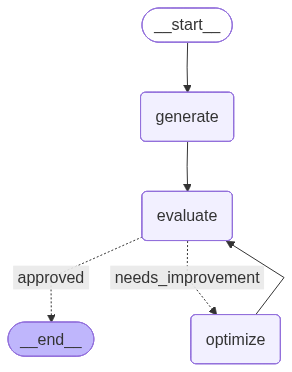

In [192]:
graph =StateGraph(TweetState)

# add nodes
graph.add_node('generate',generate_Tweet)
graph.add_node('evaluate',evaluate_Tweet)
graph.add_node('optimize',optimize_Tweet)

#create edges
graph.add_edge(START,'generate')
graph.add_edge('generate','evaluate')

# add edge with condition to either go to optimize or end for that we need a condition function above
graph.add_conditional_edges('evaluate',route_condition,{
    'approved':END,
    'needs_improvement':'optimize'
})

graph.add_edge('optimize','evaluate')

# Now run the graph
graph.compile()



In [193]:
workflow=graph.compile()
initial_state={
    'topic':' US Racism ',
    'iteration':1,
    'max_iterations':5
}
workflow.invoke(initial_state)


{'topic': ' US Racism ',
 'Tweet': AIMessage(content='"America: where equality means brunch battles over avocado toast that make WrestleMania look like a tea party. Let’s whip up a ‘culture smoothie’—now with 100% more chaos and a side of gluten-free anxiety! 🥑🥤💥 Because what\'s brunch without a sprinkle of existential dread? #BrunchBrawl"', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 71, 'prompt_tokens': 521, 'total_tokens': 592, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_c4585b5b9c', 'id': 'chatcmpl-Cq0yJHQpFkc6Ra25LceC5UZg0y0A3', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b4c5e-a285-7001-bb9a-1f753789a564-0', usage_metadata={'input_tokens':